In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt

from adtk.data import validate_series
from adtk.visualization import plot

%matplotlib inline

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

### EDA

In [2]:
df = pd.read_csv("./Covid 19 Confirmed Cases-Kerala.csv")

In [3]:
df.shape

(738, 2)

In [4]:
df.describe()

,Confirmed
count,738.000000
mean,8497.807588
std,10620.837865
min,0.000000
25%,1131.750000
50%,5046.500000
75%,11631.750000
max,55475.000000


In [5]:
df.head()

,Date,Confirmed
0,2020-01-31,0.0
1,2020-02-01,0.0
2,2020-02-02,1.0
3,2020-02-03,1.0
4,2020-02-04,0.0


In [6]:
df.set_index(pd.to_datetime(df['Date']), inplace=True)

In [7]:
df['Date'] = pd.to_datetime(df['Date'])

In [8]:
df_sample = df[df['Date'] >= '2020-10-15']

[<AxesSubplot:>]

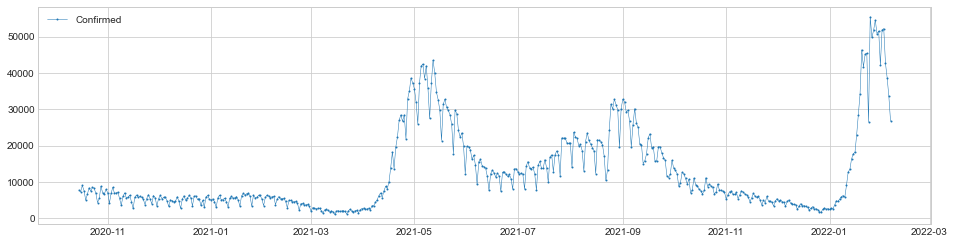

In [9]:
plot(validate_series(df_sample['Confirmed']))

[<AxesSubplot:>]

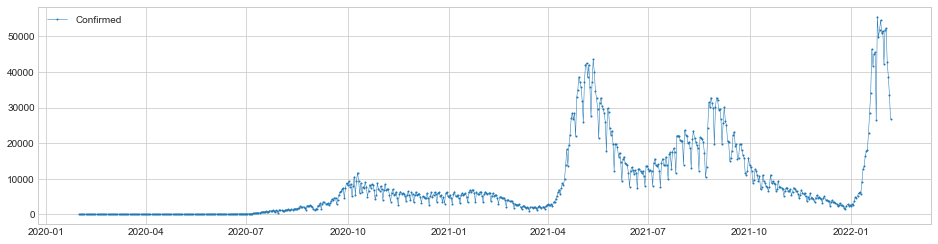

In [10]:
plot(validate_series(df['Confirmed']))

### analyzing confirmed cases

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [12]:
result = seasonal_decompose(df_sample['Confirmed'], model='add', period=1)

<AxesSubplot:xlabel='Date'>

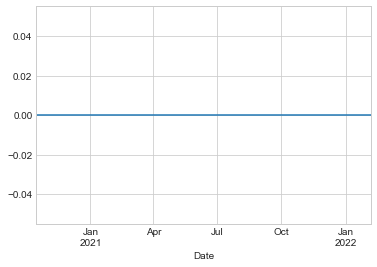

In [13]:
result.seasonal.plot()

<AxesSubplot:xlabel='Date'>

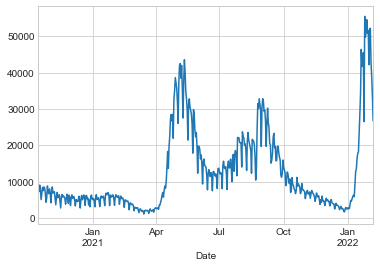

In [14]:
result.trend.plot()

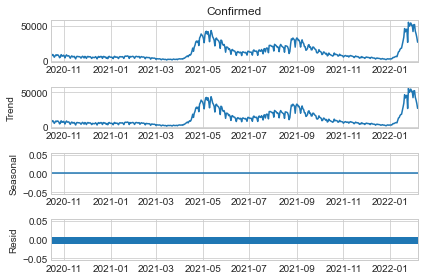

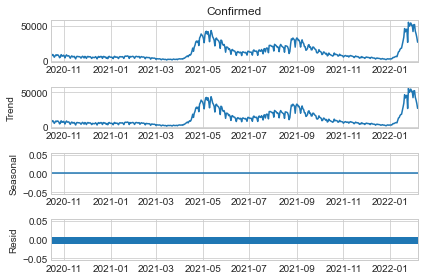

In [15]:
result.plot()

### Exponential smoothing

In [16]:
from warnings import filterwarnings
filterwarnings("ignore")

In [17]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [18]:
ts = df_sample[['Confirmed']]

In [19]:
fit1 = SimpleExpSmoothing(ts, initialization_method="heuristic").fit(
    smoothing_level=0.8, optimized=False
)
fcast1 = fit1.forecast(3).rename(r"$\alpha=0.2$")
fit2 = SimpleExpSmoothing(ts, initialization_method="heuristic").fit(
    smoothing_level=0.2, optimized=False
)
fcast2 = fit2.forecast(3).rename(r"$\alpha=0.6$")
fit3 = SimpleExpSmoothing(ts, initialization_method="estimated").fit()
fcast3 = fit3.forecast(3).rename(r"$\alpha=%s$" % fit3.model.params["smoothing_level"])

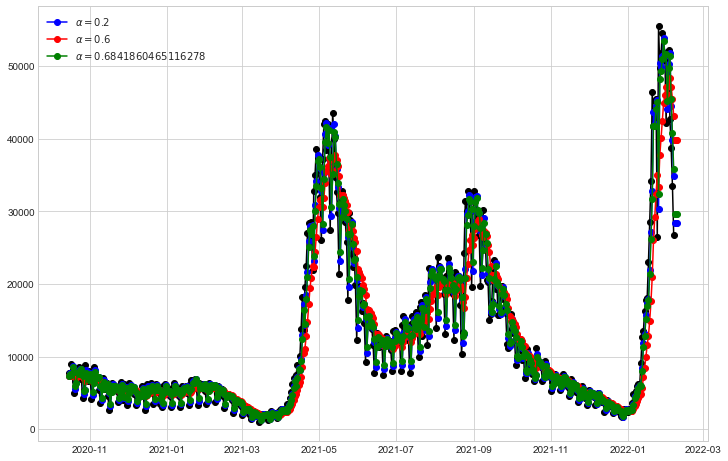

In [20]:
plt.figure(figsize=(12, 8))
plt.plot(ts, marker="o", color="black")
plt.plot(fit1.fittedvalues, marker="o", color="blue")
(line1,) = plt.plot(fcast1, marker="o", color="blue")
plt.plot(fit2.fittedvalues, marker="o", color="red")
(line2,) = plt.plot(fcast2, marker="o", color="red")
plt.plot(fit3.fittedvalues, marker="o", color="green")
(line3,) = plt.plot(fcast3, marker="o", color="green")
plt.legend([line1, line2, line3], [fcast1.name, fcast2.name, fcast3.name])

### corr analysis

In [21]:
log_ts = np.log(ts)

[<AxesSubplot:>]

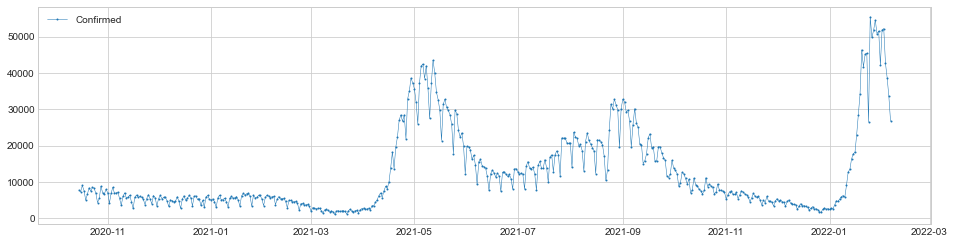

In [22]:
plot(validate_series(ts))

[<AxesSubplot:>]

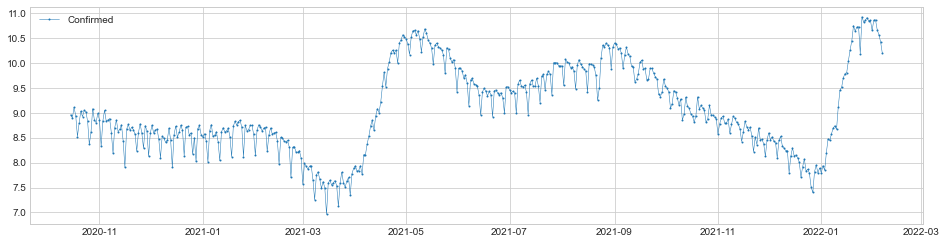

In [23]:
plot(validate_series(log_ts))

Does not look a like a stationary series

### differencing

In [24]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.DataFrame(diff)

In [25]:
diff_ts = log_ts.diff()

[<AxesSubplot:>]

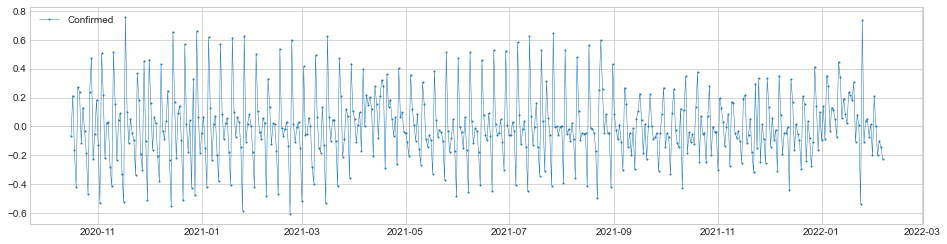

In [26]:
plot(validate_series(diff_ts))

The resulting series have constant variance (from 2020-06) and are stationary.

### 2.2 ln(St / S(t-1))

In [27]:
df = df_sample.copy()

In [28]:
df['lagged'] = df['Confirmed'].shift(-1)

In [29]:
df['fraction'] = df['Confirmed'] / df['lagged']
df['ln_fraction'] = np.log(df['fraction'])

In [30]:
df.head()

,Date,Confirmed,lagged,fraction,ln_fraction
Date,,,,,
2020-10-15,2020-10-15,7789.0,7283.0,1.069477,0.067170
2020-10-16,2020-10-16,7283.0,9016.0,0.807786,-0.213458
2020-10-17,2020-10-17,9016.0,7631.0,1.181497,0.166782
2020-10-18,2020-10-18,7631.0,5022.0,1.519514,0.418391
2020-10-19,2020-10-19,5022.0,6591.0,0.761948,-0.271877


In [31]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [32]:
df.fillna(0, inplace=True)

<AxesSubplot:>

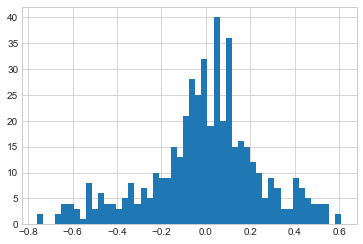

In [33]:
df['ln_fraction'].hist(bins=50)

The histogram shows a normal distribution (mean is clearly 0, stddev is close 1).

In [34]:
import statsmodels.api as sm

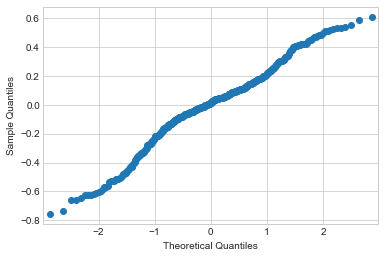

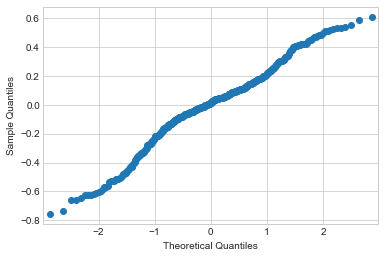

In [35]:
sm.qqplot(df['ln_fraction'])

The distribution of 2 variables is pretty similar. There are points, however, when x's values are lower than y's, and vice versa.

Kolmogorov-Smirnov test

In [36]:
from scipy.stats import kstest

In [37]:
ks_stat = kstest(df['ln_fraction'], 'norm')

In [38]:
ks_stat

KstestResult(statistic=0.2936074926205412, pvalue=3.6986841230033805e-37)

p-value is < 0.05. Null hypothesis is rejected. Distribution is normal

## Stationarity check

### Dickey-Fuller test.

In [39]:
from statsmodels.tsa.stattools import adfuller

In [40]:
result = adfuller(df.ln_fraction, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -4.121489123665621
p-value: 0.000892273165131761
Critial Values:
   1%, -3.4446148284445153
Critial Values:
   5%, -2.8678299626609314
Critial Values:
   10%, -2.5701203107928157


### Rolling statistics test.

In [41]:
index = df.set_index(df['Date'])

In [42]:
rolling_mean = index.rolling(window=12).mean()
rolling_std = index.rolling(window=12).std()

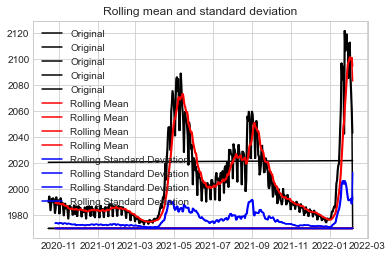

In [43]:
orig = plt.plot(index, color='black', label='Original')
mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
std = plt.plot(rolling_std, color='blue', label='Rolling Standard Deviation')

plt.legend(loc='best')
plt.title("Rolling mean and standard deviation")
plt.show(block=False)

The series is stationary.

## 2.3 ACF, PACF

In [44]:
from statsmodels.graphics import tsaplots

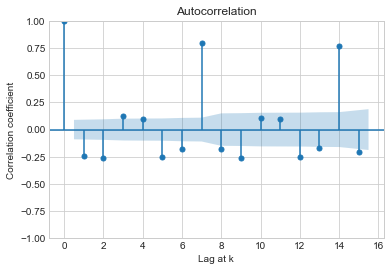

In [67]:
fig = tsaplots.plot_acf(df["ln_fraction"], lags=15)

plt.xlabel("Lag at k")
plt.ylabel("Correlation coefficient")
plt.show()

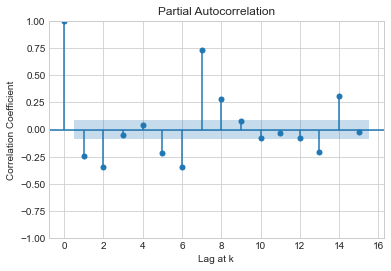

In [46]:
pacp = tsaplots.plot_pacf(df["ln_fraction"], lags=15)

plt.title("Partial Autocorrelation")
plt.xlabel("Lag at k")
plt.ylabel("Correlation Coefficient")
plt.show();

The covariance function is inconsistent.

## ACF, PACF from scratch

In [47]:
title = "ACF/PACF observations"

![title](acf_pacf.png)

In [118]:
from statsmodels.compat.scipy import _next_regular
from statsmodels.tsa.tsatools import add_trend, lagmat
from statsmodels.tools.tools import add_constant 
from statsmodels.compat.numpy import lstsq

In [106]:
def acovf(x, adjusted=False, demean=True, fft=True, missing="none", nlag=None):
    
    missing = missing.lower()
    if missing == "none":
        deal_with_masked = False
    else:
        deal_with_masked = has_missing(x)
    if deal_with_masked:
        if missing == "raise":
            raise MissingDataError("NaNs were encountered in the data")
        notmask_bool = ~np.isnan(x)  # bool
        if missing == "conservative":
            # Must copy for thread safety
            x = x.copy()
            x[~notmask_bool] = 0
        else:  # "drop"
            x = x[notmask_bool]  # copies non-missing
        notmask_int = notmask_bool.astype(int)  # int

    if demean and deal_with_masked:
        # whether "drop" or "conservative":
        xo = x - x.sum() / notmask_int.sum()
        if missing == "conservative":
            xo[~notmask_bool] = 0
    elif demean:
        xo = x - x.mean()
    else:
        xo = x

    n = len(x)
    lag_len = nlag
    if nlag is None:
        lag_len = n - 1
    elif nlag > n - 1:
        raise ValueError("nlag must be smaller than nobs - 1")

    if not fft and nlag is not None:
        acov = np.empty(lag_len + 1)
        acov[0] = xo.dot(xo)
        for i in range(lag_len):
            acov[i + 1] = xo[i + 1 :].dot(xo[: -(i + 1)])
        if not deal_with_masked or missing == "drop":
            if adjusted:
                acov /= n - np.arange(lag_len + 1)
            else:
                acov /= n
        else:
            if adjusted:
                divisor = np.empty(lag_len + 1, dtype=np.int64)
                divisor[0] = notmask_int.sum()
                for i in range(lag_len):
                    divisor[i + 1] = notmask_int[i + 1 :].dot(
                        notmask_int[: -(i + 1)]
                    )
                divisor[divisor == 0] = 1
                acov /= divisor
            else:  # biased, missing data but npt "drop"
                acov /= notmask_int.sum()
        return acov

    if adjusted and deal_with_masked and missing == "conservative":
        d = np.correlate(notmask_int, notmask_int, "full")
        d[d == 0] = 1
    elif adjusted:
        xi = np.arange(1, n + 1)
        d = np.hstack((xi, xi[:-1][::-1]))
    elif deal_with_masked:
        # biased and NaNs given and ("drop" or "conservative")
        d = notmask_int.sum() * np.ones(2 * n - 1)
    else:  # biased and no NaNs or missing=="none"
        d = n * np.ones(2 * n - 1)

    if fft:
        nobs = len(xo)
        n = _next_regular(2 * nobs + 1)
        Frf = np.fft.fft(xo, n=n)
        acov = np.fft.ifft(Frf * np.conjugate(Frf))[:nobs] / d[nobs - 1 :]
        acov = acov.real
    else:
        acov = np.correlate(xo, xo, "full")[n - 1 :] / d[n - 1 :]

    if nlag is not None:
        # Copy to allow gc of full array rather than view
        return acov[: lag_len + 1].copy()
    return acov

In [107]:
def acf(
    x,
    adjusted=False,
    nlags=None,
    qstat=False,
    fft=True,
    alpha=None,
    bartlett_confint=True,
    missing="none",
):

    nobs = x.shape[0]
    if nlags is None:
        nlags = min(int(10 * np.log10(nobs)), nobs - 1)

    avf = acovf(x, adjusted=adjusted, demean=True, fft=fft, missing=missing)
    acf = avf[: nlags + 1] / avf[0]
    if not (qstat or alpha):
        return acf
    if alpha is not None:
        if bartlett_confint:
            varacf = np.ones_like(acf) / nobs
            varacf[0] = 0
            varacf[1] = 1.0 / nobs
            varacf[2:] *= 1 + 2 * np.cumsum(acf[1:-1] ** 2)
        else:
            varacf = 1.0 / len(x)
        interval = stats.norm.ppf(1 - alpha / 2.0) * np.sqrt(varacf)
        confint = np.array(lzip(acf - interval, acf + interval))
        if not qstat:
            return acf, confint
    if qstat:
        qstat, pvalue = q_stat(acf[1:], nobs=nobs)  # drop lag 0
        if alpha is not None:
            return acf, confint, qstat, pvalue
        else:
            return acf, qstat, pvalue

In [108]:
def pacf_ols(x, nlags=None, efficient=True, adjusted=False):
    
    nobs = x.shape[0]
    if nlags is None:
        nlags = min(int(10 * np.log10(nobs)), nobs - 1)

    pacf = np.empty(nlags + 1)
    pacf[0] = 1.0
    if efficient:
        xlags, x0 = lagmat(x, nlags, original="sep")
        xlags = add_constant(xlags)
        for k in range(1, nlags + 1):
            params = lstsq(xlags[k:, : k + 1], x0[k:], rcond=None)[0]
            pacf[k] = params[-1]
    else:
        x = x - np.mean(x)
        # Create a single set of lags for multivariate OLS
        xlags, x0 = lagmat(x, nlags, original="sep", trim="both")
        for k in range(1, nlags + 1):
            params = lstsq(xlags[:, :k], x0, rcond=None)[0]
            # Last coefficient corresponds to PACF value (see [1])
            pacf[k] = params[-1]

    if adjusted:
        pacf *= nobs / (nobs - np.arange(nlags + 1))

    return pacf

In [109]:
def pacf(x, nlags=None, method="ols", alpha=None):
    
    methods = (
        "ols",
        "ols-inefficient",
        "ols-adjusted",
        "yw",
        "ywa",
        "ld",
        "ywadjusted",
        "yw_adjusted",
        "ywm",
        "ywmle",
        "yw_mle",
        "lda",
        "ldadjusted",
        "ld_adjusted",
        "ldb",
        "ldbiased",
        "ld_biased",
        "burg"
    )

    nobs = x.shape[0]
    if nlags is None:
        nlags = min(int(10 * np.log10(nobs)), nobs // 2 - 1)
    if nlags >= x.shape[0] // 2:
        raise ValueError(
            "Can only compute partial correlations for lags up to 50% of the "
            f"sample size. The requested nlags {nlags} must be < "
            f"{x.shape[0] // 2}."
        )

    if method in ("ols", "ols-inefficient", "ols-adjusted"):
        efficient = "inefficient" not in method
        adjusted = "adjusted" in method
        ret = pacf_ols(x, nlags=nlags, efficient=efficient, adjusted=adjusted)
#     elif method in ("yw", "ywa", "ywadjusted", "yw_adjusted"):
#         ret = pacf_yw(x, nlags=nlags, method="adjusted")
#     elif method in ("ywm", "ywmle", "yw_mle"):
#         ret = pacf_yw(x, nlags=nlags, method="mle")
#     elif method in ("ld", "lda", "ldadjusted", "ld_adjusted"):
#         acv = acovf(x, adjusted=True, fft=False)
#         ld_ = levinson_durbin(acv, nlags=nlags, isacov=True)
#         ret = ld_[2]
#     elif method == "burg":
#         ret, _ = pacf_burg(x, nlags=nlags, demean=True)
        
    # inconsistent naming with ywmle
#     else:  # method in ("ldb", "ldbiased", "ld_biased")
#         acv = acovf(x, adjusted=False, fft=False)
#         ld_ = levinson_durbin(acv, nlags=nlags, isacov=True)
#         ret = ld_[2]

    if alpha is not None:
        varacf = 1.0 / len(x)  # for all lags >=1
        interval = stats.norm.ppf(1.0 - alpha / 2.0) * np.sqrt(varacf)
        confint = np.array(lzip(ret - interval, ret + interval))
        confint[0] = ret[0]  # fix confidence interval for lag 0 to varpacf=0
        return ret, confint
    else:
        return ret

In [110]:
acf_v1 = acf(df["ln_fraction"], nlags=15)

In [115]:
pacf_v1 = pacf(df["ln_fraction"], nlags=15)

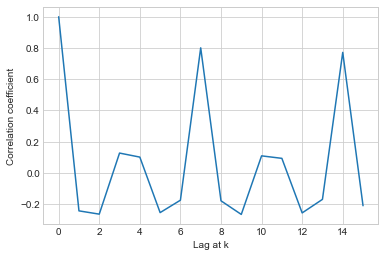

In [116]:
plt.xlabel("Lag at k")
plt.ylabel("Correlation coefficient")
plt.plot(acf_v1)
plt.show()

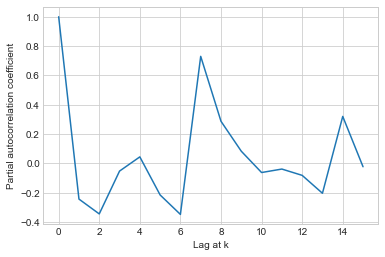

In [117]:
plt.xlabel("Lag at k")
plt.ylabel("Partial autocorrelation coefficient")
plt.plot(pacf_v1)
plt.show()

## AR(1, 2)

In [129]:
from statsmodels.tsa.arima.model import ARIMA

In [130]:
model_ar = ARIMA(df["ln_fraction"], order=(1, 0, 0))
results_ar = model_ar.fit()

In [132]:
results_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            ln_fraction   No. Observations:                  480
Model:                 ARIMA(1, 0, 0)   Log Likelihood                  -4.360
Date:                Tue, 22 Feb 2022   AIC                             14.719
Time:                        11:34:01   BIC                             27.241
Sample:                    10-15-2020   HQIC                            19.641
                         - 02-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0026      0.010     -0.268      0.788      -0.022       0.016
ar.L1         -0.2427      0.040     -6.092      0.000      -0.321      -0.165
sigma2         0.0596      0.004     15.270      0.000       0.052       0.067
===================================================================================
Ljung-Box (L1) (Q):                   3.40   Jarque-Bera (JB):                 0.29
Prob(Q):                              0.07   Prob(JB):                         0.86
Heteroskedasticity (H):               0.46   Skew:                             0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [134]:
## higher order model
model_ar_2 = ARIMA(df['ln_fraction'], order=(2, 0, 0))
results_ar_2 = model_ar_2.fit()
results_ar_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            ln_fraction   No. Observations:                  480
Model:                 ARIMA(2, 0, 0)   Log Likelihood                  25.766
Date:                Tue, 22 Feb 2022   AIC                            -43.532
Time:                        11:35:56   BIC                            -26.837
Sample:                    10-15-2020   HQIC                           -36.969
                         - 02-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0026      0.007     -0.375      0.707      -0.016       0.011
ar.L1         -0.3262      0.042     -7.780      0.000      -0.408      -0.244
ar.L2         -0.3433      0.053     -6.466      0.000      -0.447      -0.239
sigma2         0.0526      0.003     15.621      0.000       0.046       0.059
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                 9.71
Prob(Q):                              0.68   Prob(JB):                         0.01
Heteroskedasticity (H):               0.60   Skew:                             0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [136]:
from scipy.stats.distributions import chi2

In [148]:
def LLR_test(model_1, model_2, DF=1):
    
    L1 = model_1.fit().llf
    L2 = model_2.fit().llf
    LR = (2 * (L2 - L1))
    p = chi2.sf(LR, DF).round(3)
    
    return p

In [140]:
LLR_test(model_ar, model_ar_2)

0.0

AR(2) is statistically more significant than AR(1)

## MA(1, 2)

In [141]:
## MA(1)
model_ma_1 = ARIMA(df['ln_fraction'], order=(0, 0, 1))
results_ma_1 = model_ma_1.fit()
results_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            ln_fraction   No. Observations:                  480
Model:                 ARIMA(0, 0, 1)   Log Likelihood                  12.871
Date:                Tue, 22 Feb 2022   AIC                            -19.743
Time:                        11:38:57   BIC                             -7.221
Sample:                    10-15-2020   HQIC                           -14.821
                         - 02-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0028      0.006     -0.438      0.661      -0.015       0.010
ma.L1         -0.4589      0.038    -12.109      0.000      -0.533      -0.385
sigma2         0.0555      0.004     15.351      0.000       0.048       0.063
===================================================================================
Ljung-Box (L1) (Q):                   2.66   Jarque-Bera (JB):                15.27
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                             0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [142]:
## MA(2)
model_ma_2 = ARIMA(df['ln_fraction'], order=(0, 0, 2))
results_ma_2 = model_ma_2.fit()
results_ma_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            ln_fraction   No. Observations:                  480
Model:                 ARIMA(0, 0, 2)   Log Likelihood                  20.238
Date:                Tue, 22 Feb 2022   AIC                            -32.475
Time:                        11:39:31   BIC                            -15.780
Sample:                    10-15-2020   HQIC                           -25.913
                         - 02-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0029      0.006     -0.477      0.633      -0.015       0.009
ma.L1         -0.3140      0.043     -7.376      0.000      -0.397      -0.231
ma.L2         -0.1804      0.053     -3.429      0.001      -0.284      -0.077
sigma2         0.0538      0.003     15.751      0.000       0.047       0.060
===================================================================================
Ljung-Box (L1) (Q):                   0.51   Jarque-Bera (JB):                 6.36
Prob(Q):                              0.48   Prob(JB):                         0.04
Heteroskedasticity (H):               0.59   Skew:                             0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [144]:
LLR_test(model_ma_1, model_ma_2)

0.0

MA(2) is statistically more significant than MA(1)

## ARMA(1, 1)

In [145]:
## ARMA(1)
model_arma_1 = ARIMA(df['ln_fraction'], order=(1, 0, 1))
results_arma_1 = model_arma_1.fit()
results_arma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            ln_fraction   No. Observations:                  480
Model:                 ARIMA(1, 0, 1)   Log Likelihood                  16.456
Date:                Tue, 22 Feb 2022   AIC                            -24.912
Time:                        11:41:09   BIC                             -8.217
Sample:                    10-15-2020   HQIC                           -18.350
                         - 02-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0028      0.006     -0.464      0.642      -0.015       0.009
ar.L1          0.1940      0.105      1.847      0.065      -0.012       0.400
ma.L1         -0.5854      0.086     -6.845      0.000      -0.753      -0.418
sigma2         0.0546      0.004     15.494      0.000       0.048       0.062
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):                10.86
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):               0.58   Skew:                             0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

AR coef is insignificant (p-value > 0.05)

#### arma(1, 1) is statistically more significant than MA(1)

In [149]:
LLR_test(model_ma_1, model_arma_1)

0.007

#### arma(1, 1) is statistically more significant than AR(1)

In [152]:
LLR_test(model_ar, model_arma_1)

0.0

## ARIMA / SARIMA

### ARIMA(1, 1, 1)

In [153]:
model_ar_1_i_1_ma_1 = ARIMA(df['ln_fraction'], order=(1, 1, 1))
results_ar_1_i_1_ma_1 = model_ar_1_i_1_ma_1.fit()
results_ar_1_i_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            ln_fraction   No. Observations:                  480
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  -8.154
Date:                Tue, 22 Feb 2022   AIC                             22.307
Time:                        11:49:20   BIC                             34.822
Sample:                    10-15-2020   HQIC                            27.227
                         - 02-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2411      0.037     -6.550      0.000      -0.313      -0.169
ma.L1         -0.9998      0.378     -2.644      0.008      -1.741      -0.259
sigma2         0.0597      0.023      2.623      0.009       0.015       0.104
===================================================================================
Ljung-Box (L1) (Q):                   3.42   Jarque-Bera (JB):                 0.05
Prob(Q):                              0.06   Prob(JB):                         0.98
Heteroskedasticity (H):               0.46   Skew:                             0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### arma(1, 1) is statistically more significant than arima(1, 1, 1)

In [154]:
LLR_test(model_arma_1, model_ar_1_i_1_ma_1)

1.0

### arima(1,1,1) residuals

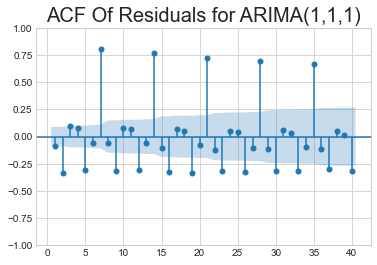

In [159]:
df_copy = df.copy()
df_copy['res_ar_1_i_1_ma_1'] = results_ar_1_i_1_ma_1.resid
sgt.plot_acf(df_copy.res_ar_1_i_1_ma_1, zero = False, lags = 40)
plt.title("ACF Of Residuals for ARIMA(1,1,1)",size=20)
plt.show()

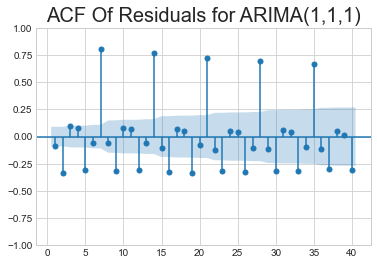

In [160]:
df['res_ar_1_i_1_ma_1'] = results_ar_1_i_1_ma_1.resid.iloc[:]
sgt.plot_acf(df.res_ar_1_i_1_ma_1[1:], zero = False, lags = 40)
plt.title("ACF Of Residuals for ARIMA(1,1,1)",size=20)
plt.show()

## Higher-lag ARIMA models

In [165]:
model_ar_1_i_1_ma_2 = ARIMA(df["ln_fraction"], order=(1,1,2))
results_ar_1_i_1_ma_2 = model_ar_1_i_1_ma_2.fit()
model_ar_1_i_1_ma_3 = ARIMA(df["ln_fraction"], order=(1,1,3))
results_ar_1_i_1_ma_3 = model_ar_1_i_1_ma_3.fit()
model_ar_2_i_1_ma_1 = ARIMA(df["ln_fraction"], order=(2,1,1))
results_ar_2_i_1_ma_1 = model_ar_2_i_1_ma_1.fit()
model_ar_3_i_1_ma_1 = ARIMA(df["ln_fraction"], order=(3,1,1))
results_ar_3_i_1_ma_1 = model_ar_3_i_1_ma_1.fit()
model_ar_3_i_1_ma_2 = ARIMA(df["ln_fraction"], order=(3,1,2))
results_ar_3_i_1_ma_2 = model_ar_3_i_1_ma_2.fit()

In [166]:
print("ARIMA(1,1,1):  \t LL = ", results_ar_1_i_1_ma_1.llf, "\t AIC = ", results_ar_1_i_1_ma_1.aic)
print("ARIMA(1,1,2):  \t LL = ", results_ar_1_i_1_ma_2.llf, "\t AIC = ", results_ar_1_i_1_ma_2.aic)
print("ARIMA(1,1,3):  \t LL = ", results_ar_1_i_1_ma_3.llf, "\t AIC = ", results_ar_1_i_1_ma_3.aic)
print("ARIMA(2,1,1):  \t LL = ", results_ar_2_i_1_ma_1.llf, "\t AIC = ", results_ar_2_i_1_ma_1.aic)
print("ARIMA(3,1,1):  \t LL = ", results_ar_3_i_1_ma_1.llf, "\t AIC = ", results_ar_3_i_1_ma_1.aic)
print("ARIMA(3,1,2):  \t LL = ", results_ar_3_i_1_ma_2.llf, "\t AIC = ", results_ar_3_i_1_ma_2.aic)

ARIMA(1,1,1):  	 LL =  -8.153617952250315 	 AIC =  22.30723590450063
ARIMA(1,1,2):  	 LL =  -17.07600596948606 	 AIC =  42.15201193897212
ARIMA(1,1,3):  	 LL =  51.439238927577385 	 AIC =  -92.87847785515477
ARIMA(2,1,1):  	 LL =  21.615040260925824 	 AIC =  -35.23008052185165
ARIMA(3,1,1):  	 LL =  22.404252382326554 	 AIC =  -34.80850476465311
ARIMA(3,1,2):  	 LL =  26.74307111109981 	 AIC =  -41.48614222219962


In [168]:
print("\nLLR test p-value = " + str(LLR_test(model_ar_1_i_1_ma_2, model_ar_1_i_1_ma_3)))


LLR test p-value = 0.0


In [169]:
print("\nLLR test p-value = " + str(LLR_test(model_ar_1_i_1_ma_1, model_ar_1_i_1_ma_3, DF = 2)))


LLR test p-value = 0.0


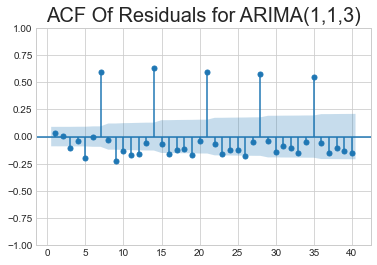

In [170]:
df['res_ar_1_i_1_ma_3'] = results_ar_1_i_1_ma_3.resid
sgt.plot_acf(df.res_ar_1_i_1_ma_3[1:], zero = False, lags = 40)
plt.title("ACF Of Residuals for ARIMA(1,1,3)", size=20)
plt.show()

### more higher-order models

In [173]:
model_ar_5_i_1_ma_1 = ARIMA(df["ln_fraction"], order=(5,1,1))
results_ar_5_i_1_ma_1 = model_ar_5_i_1_ma_1.fit()
model_ar_6_i_1_ma_3 = ARIMA(df["ln_fraction"], order=(6,1,3))
results_ar_6_i_1_ma_3 = model_ar_6_i_1_ma_3.fit()

In [174]:
results_ar_5_i_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            ln_fraction   No. Observations:                  480
Model:                 ARIMA(5, 1, 1)   Log Likelihood                  45.774
Date:                Tue, 22 Feb 2022   AIC                            -77.548
Time:                        11:58:53   BIC                            -48.346
Sample:                    10-15-2020   HQIC                           -66.068
                         - 02-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4644      0.044    -10.477      0.000      -0.551      -0.378
ar.L2         -0.5307      0.061     -8.762      0.000      -0.649      -0.412
ar.L3         -0.3228      0.073     -4.400      0.000      -0.467      -0.179
ar.L4         -0.1991      0.067     -2.989      0.003      -0.330      -0.069
ar.L5         -0.3318      0.061     -5.472      0.000      -0.451      -0.213
ma.L1         -0.8637      0.032    -27.156      0.000      -0.926      -0.801
sigma2         0.0480      0.003     16.023      0.000       0.042       0.054
===================================================================================
Ljung-Box (L1) (Q):                  18.91   Jarque-Bera (JB):                44.64
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.62   Skew:                             0.69
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [177]:
results_ar_6_i_1_ma_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            ln_fraction   No. Observations:                  480
Model:                 ARIMA(6, 1, 3)   Log Likelihood                 265.045
Date:                Tue, 22 Feb 2022   AIC                           -510.089
Time:                        12:00:08   BIC                           -468.372
Sample:                    10-15-2020   HQIC                          -493.690
                         - 02-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9250      0.031    -29.827      0.000      -0.986      -0.864
ar.L2         -0.9446      0.032    -29.501      0.000      -1.007      -0.882
ar.L3         -0.9219      0.031    -29.338      0.000      -0.983      -0.860
ar.L4         -0.9032      0.029    -31.468      0.000      -0.959      -0.847
ar.L5         -0.9037      0.027    -33.331      0.000      -0.957      -0.851
ar.L6         -0.8350      0.025    -33.579      0.000      -0.884      -0.786
ma.L1         -0.4440      0.040    -11.127      0.000      -0.522      -0.366
ma.L2          0.0690      0.056      1.240      0.215      -0.040       0.178
ma.L3          0.1456      0.048      3.027      0.002       0.051       0.240
sigma2         0.0190      0.001     22.776      0.000       0.017       0.021
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               175.23
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.07   Skew:                             0.42
Prob(H) (two-sided):                  0.68   Kurtosis:                         5.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [176]:
print("ARIMA(1,1,3):  \t LL = ", results_ar_1_i_1_ma_3.llf, "\t AIC = ", results_ar_1_i_1_ma_3.aic)
print("ARIMA(5,1,1):  \t LL = ", results_ar_5_i_1_ma_1.llf, "\t AIC = ", results_ar_5_i_1_ma_1.aic)
print("ARIMA(6,1,3):  \t LL = ", results_ar_6_i_1_ma_3.llf, "\t AIC = ", results_ar_6_i_1_ma_3.aic)

ARIMA(1,1,3):  	 LL =  51.439238927577385 	 AIC =  -92.87847785515477
ARIMA(5,1,1):  	 LL =  45.7738714026382 	 AIC =  -77.5477428052764
ARIMA(6,1,3):  	 LL =  265.0446703000366 	 AIC =  -510.0893406000732


In [178]:
print("\nLLR test p-value = " + str(LLR_test(model_ar_1_i_1_ma_3, model_ar_6_i_1_ma_3, DF = 5)))


LLR test p-value = 0.0


In [179]:
print("\nLLR test p-value = " + str(LLR_test(model_ar_5_i_1_ma_1, model_ar_6_i_1_ma_3, DF = 3)))


LLR test p-value = 0.0


ARIMA(6, 1, 3) is much more statistically significant than all the other models.

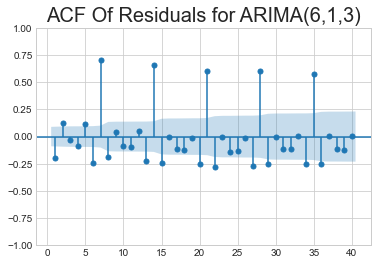

In [181]:
df['res_ar_6_i_1_ma_3'] = results_ar_5_i_1_ma_1.resid
sgt.plot_acf(df.res_ar_6_i_1_ma_3[1:], zero = False, lags = 40)
plt.title("ACF Of Residuals for ARIMA(6,1,3)", size=20)
plt.show()

### SARIMAX - Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model

In [182]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [185]:
model_sarimax = SARIMAX(df['ln_fraction'], exog = df['ln_fraction'], order=(1,0,1), seasonal_order = (2,0,1,3))
results_sarimax = model_sarimax.fit()
results_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                       ln_fraction   No. Observations:                  480
Model:             SARIMAX(1, 0, 1)x(2, 0, 1, 3)   Log Likelihood                5084.785
Date:                           Tue, 22 Feb 2022   AIC                         -10155.570
Time:                                   12:07:39   BIC                         -10126.353
Sample:                               10-15-2020   HQIC                        -10144.086
                                    - 02-06-2022                                         
Covariance Type:                             opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
ln_fraction     1.0000   2.11e-26   4.73e+25      0.000       1.000       1.000
ar.L1           0.2443   1.57e-22   1.55e+21      0.000       0.244       0.244
ma.L1          -0.5841   2.62e-22  -2.23e+21      0.000      -0.584      -0.584
ar.S.L3         0.5089   3.22e-22   1.58e+21      0.000       0.509       0.509
ar.S.L6        -0.2403   7.48e-22  -3.21e+20      0.000      -0.240      -0.240
ma.S.L3        -0.4972   4.42e-22  -1.12e+21      0.000      -0.497      -0.497
sigma2           1e-10   9.05e-11      1.105      0.269   -7.73e-11    2.77e-10
===================================================================================
Ljung-Box (L1) (Q):                   4.85   Jarque-Bera (JB):                 4.20
Prob(Q):                              0.03   Prob(JB):                         0.12
Heteroskedasticity (H):               0.58   Skew:                             0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.74e+43. Standard errors may be unstable.
"""

In [186]:
print("\nLLR test p-value = " + str(LLR_test(model_ar_6_i_1_ma_3, model_sarimax, DF = 2)))


LLR test p-value = 0.0


## SARIMAX(1,0,1) Seasonal(2,0,1,3) proves to be the best model

References:
* https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_acf.html
* https://medium.com/ethereum-crypto-currency-time-series-forecasting/ethereum-crypto-currency-time-series-forecasting-with-arima-sarima-fd7e3e884b0b
* https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/